In [3]:
#pip install xgboost

In [4]:
import pandas as pd
import numpy as np


In [5]:
df.info()

NameError: name 'df' is not defined

In [6]:
df = pd.read_excel("dataset_final.xlsx")
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'])

df = df.sort_values('TANGGAL')
df = df.reset_index(drop=True)

In [7]:
df['Rain'] = df['RR'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
train = df[df['TANGGAL'] < "2022-01-01"]
val   = df[(df['TANGGAL'] >= "2022-01-01") & (df['TANGGAL'] < "2024-01-01")]
test  = df[df['TANGGAL'] >= "2024-01-01"]

In [9]:
def create_features(df):
    df = df.copy()

    # -----------------------------
    # 1. Lag Features
    # -----------------------------
    df['RR_lag1'] = df['RR'].shift(1)
    df['RR_lag7'] = df['RR'].shift(7)
    df['TAVG_lag1'] = df['TAVG'].shift(1)

    # Change / difference
    df['RR_diff1'] = df['RR'] - df['RR_lag1']
    df['RH_diff1'] = df['RH_AVG'] - df['RH_AVG'].shift(1)

    # -----------------------------
    # 2. Rolling Features
    # -----------------------------
    df['RR_7d'] = df['RR'].rolling(window=7).mean()
    df['RR_30d'] = df['RR'].rolling(window=30).mean()

    # Count berapa hari hujan dalam 7 hari terakhir
    df['Rain_7d_count'] = df['RR'].apply(lambda x: 1 if x > 0 else 0).rolling(7).sum()

    # -----------------------------
    # 3. Cyclic Date Encoding
    # -----------------------------
    df['month'] = df['TANGGAL'].dt.month
    df['day']   = df['TANGGAL'].dt.day

    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)

    df['day_sin'] = np.sin(2*np.pi*df['day']/31)
    df['day_cos'] = np.cos(2*np.pi*df['day']/31)

    # -----------------------------
    # 4. Weather–based engineered features
    # -----------------------------
    # Rentang suhu harian
    df['temp_range'] = df['TX'] - df['TN']

    # -----------------------------
    # 5. Season encoding (musim Indonesia)
    # -----------------------------
    def month_to_season(m):
        if m in [12, 1, 2]:
            return 1   # Musim Hujan
        elif m in [3, 4, 5]:
            return 2   # Pancaroba 1
        elif m in [6, 7, 8]:
            return 3   # Musim Kemarau
        else:
            return 4   # Pancaroba 2

    df['season'] = df['month'].apply(month_to_season)

    return df


In [10]:
train_fe = create_features(train)
val_fe   = create_features(val)
test_fe  = create_features(test)

train_fe = train_fe.dropna()
val_fe   = val_fe.dropna()
test_fe  = test_fe.dropna()


In [11]:
feature_cols = [
    'TN','TX','TAVG','RH_AVG','SS','FF_X','DDD_X','FF_AVG','DDD_CAR',
    'RR_lag1','RR_lag7','TAVG_lag1',
    'RR_7d','RR_30d',
    'month_sin','month_cos','day_sin','day_cos'
]

X_train = train_fe[feature_cols]
y_train = train_fe['Rain']

X_val   = val_fe[feature_cols]
y_val   = val_fe['Rain']

X_test  = test_fe[feature_cols]
y_test  = test_fe['Rain']


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)   # hanya training!

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


# Data Modelling

In [13]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


## LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_lstm   = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
X_test_lstm  = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_train_scaled.shape[1])),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=25,
    batch_size=32
)

prob_lstm = model_lstm.predict(X_test_lstm).ravel()
pred_lstm = (prob_lstm > 0.5).astype(int)


Epoch 1/25


c:\Users\Ayu Sekar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7213 - loss: 0.5795 - val_accuracy: 0.7033 - val_loss: 0.5610
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7610 - loss: 0.4935 - val_accuracy: 0.7247 - val_loss: 0.5478
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7673 - loss: 0.4698 - val_accuracy: 0.7332 - val_loss: 0.5295
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7752 - loss: 0.4566 - val_accuracy: 0.7518 - val_loss: 0.5203
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7795 - loss: 0.4492 - val_accuracy: 0.7532 - val_loss: 0.5115
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7862 - loss: 0.4434 - val_accuracy: 0.7475 - val_loss: 0.5344
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7885 - loss: 0.4402 - val_accuracy: 0.7561 - val_loss: 0.5082
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7936 - loss: 0.4349 - val_accuracy: 0.7532 - val_loss: 0.5164
Epo

## XGBoost

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.7,
    eval_metric='logloss'
)
model_xgb.fit(X_train_scaled, y_train)

pred_xgb = model_xgb.predict(X_test_scaled)
prob_xgb = model_xgb.predict_proba(X_test_scaled)[:,1]

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=300, random_state=42)
model_rf.fit(X_train_scaled, y_train)

pred_rf = model_rf.predict(X_test_scaled)
prob_rf = model_rf.predict_proba(X_test_scaled)[:,1]


📌 HASIL MODEL: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       307
           1       0.73      0.83      0.78       344

    accuracy                           0.75       651
   macro avg       0.75      0.74      0.74       651
weighted avg       0.75      0.75      0.74       651



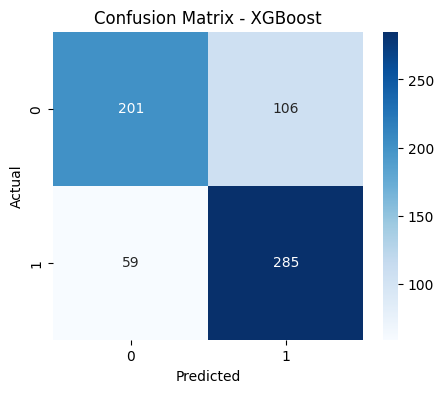

In [ ]:
show_results("XGBoost", y_test, pred_xgb)


📌 HASIL MODEL: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       307
           1       0.75      0.81      0.78       344

    accuracy                           0.76       651
   macro avg       0.76      0.76      0.76       651
weighted avg       0.76      0.76      0.76       651



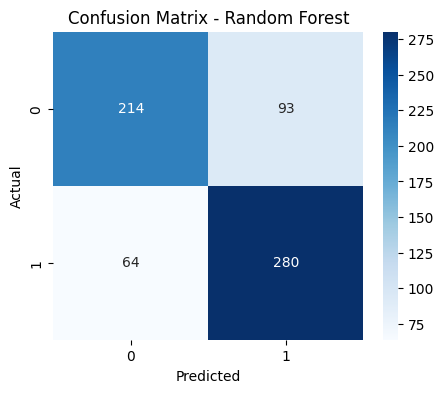

In [ ]:
show_results("Random Forest", y_test, pred_rf)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

📌 HASIL MODEL: LSTM

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       307
           1       0.72      0.77      0.74       344

    accuracy                           0.72       651
   macro avg       0.72      0.72      0.72       651
weighted avg       0.72      0.72      0.72       651



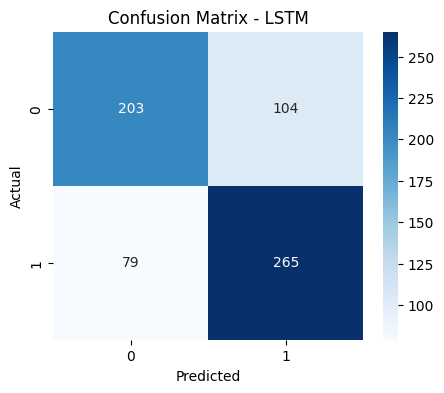

In [ ]:
pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype(int)
show_results("LSTM", y_test, pred_lstm)


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       307
           1       0.75      0.81      0.78       344

    accuracy                           0.76       651
   macro avg       0.76      0.76      0.76       651
weighted avg       0.76      0.76      0.76       651



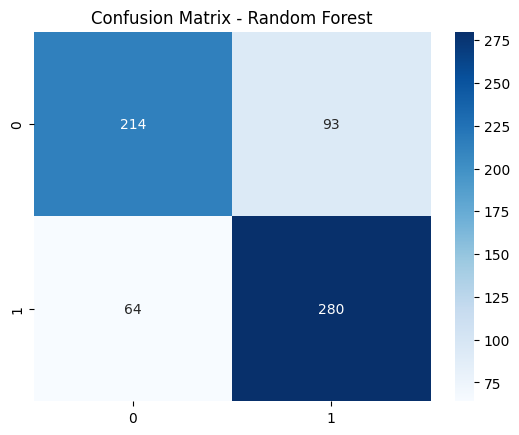

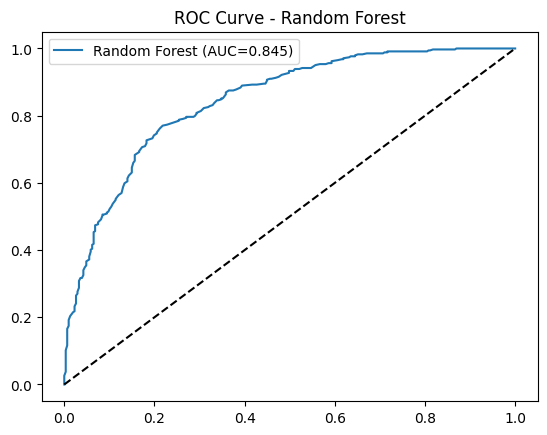


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       307
           1       0.73      0.83      0.78       344

    accuracy                           0.75       651
   macro avg       0.75      0.74      0.74       651
weighted avg       0.75      0.75      0.74       651



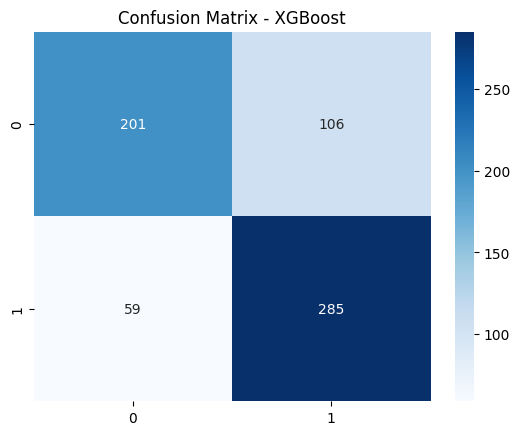

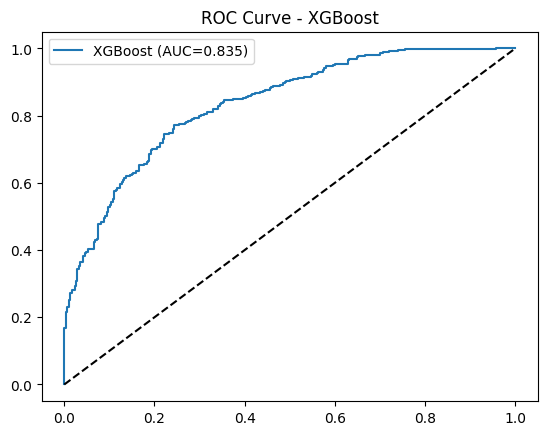


=== LSTM ===
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       307
           1       0.72      0.77      0.74       344

    accuracy                           0.72       651
   macro avg       0.72      0.72      0.72       651
weighted avg       0.72      0.72      0.72       651



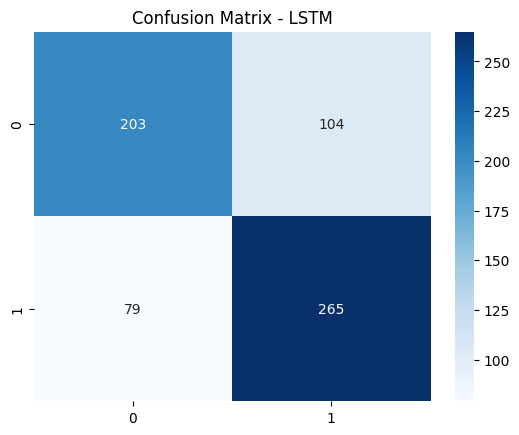

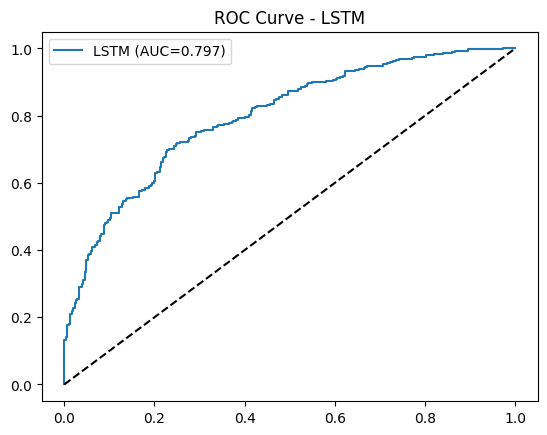

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    plt.title(f"ROC Curve - {name}")
    plt.show()

# panggil evaluasi
evaluate_model("Random Forest", y_test, pred_rf, prob_rf)
evaluate_model("XGBoost", y_test, pred_xgb, prob_xgb)
evaluate_model("LSTM", y_test, pred_lstm, prob_lstm)


# Ensemble 

In [ ]:
def make_sequence(X, y, window=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

# LSTM needs sequence
X_train_lstm, y_train_lstm = make_sequence(X_train_scaled, y_train.values, window=7)
X_val_lstm,   y_val_lstm   = make_sequence(X_val_scaled, y_val.values, window=7)
X_test_lstm,  y_test_lstm  = make_sequence(X_test_scaled, y_test.values, window=7)
